# Simple calibration example

True process: $\zeta = \frac{\theta x}{1+x/a}$

In [1]:
import numpy as np
import random
import matplotlib.pyplot as plt
import pymc as pm
import scipy

WARNING (pytensor.configdefaults): g++ not available, if using conda: `conda install m2w64-toolchain`
WARNING (pytensor.configdefaults): g++ not detected!  PyTensor will be unable to compile C-implementations and will default to Python. Performance may be severely degraded. To remove this warning, set PyTensor flags cxx to an empty string.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
x= np.linspace(0,6,100) # x values
xReg = np.linspace(0.1,4,11) # regularly spaced observations
xRan = np.random.uniform(0.1,4,11) # randomly located observations

In [3]:
theta = 0.65
a = 20
eta = theta*x
zeta = theta*x/(1+x/a) #true process
zReg = theta*xReg/(1+xReg/a)+np.random.normal(0,0.001,len(xReg)) #Regularly spaced observations
zRan = theta*xRan/(1+xRan/a)+np.random.normal(0,0.001,len(xRan)) #Randomly spaced observations

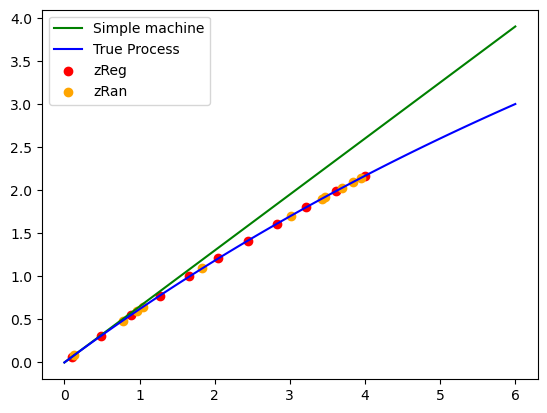

In [4]:
plt.plot(x,eta,color='g')
plt.plot(x,zeta,color='b')
plt.scatter(xReg,zReg,color='r')
plt.scatter(xRan,zRan,color='orange') 
plt.legend(['Simple machine','True Process','zReg', 'zRan'])

In [5]:
np.array([zReg,xReg]).T

array([[0.06438088, 0.1       ],
       [0.30963593, 0.49      ],
       [0.5490303 , 0.88      ],
       [0.77606896, 1.27      ],
       [0.99804487, 1.66      ],
       [1.20831537, 2.05      ],
       [1.41313173, 2.44      ],
       [1.61143037, 2.83      ],
       [1.80269971, 3.22      ],
       [1.98773408, 3.61      ],
       [2.16615073, 4.        ]])

# Bayesian Linear Regression using Bambi

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [zReg_sigma, xReg]


Sampling 1 chain for 1_000 tune and 5_000 draw iterations (1_000 + 5_000 draws total) took 22 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [zRan_sigma, xRan]


Sampling 1 chain for 1_000 tune and 5_000 draw iterations (1_000 + 5_000 draws total) took 29 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks
arviz - WARNING - Shape validation failed: input_shape: (1, 5000), minimum_shape: (chains=2, draws=4)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
xReg,0.563,0.008,0.548,0.577,0.0,0.0,2895.0,2593.0,NaN
zReg_sigma,0.059,0.016,0.033,0.086,0.0,0.0,3420.0,2896.0,NaN


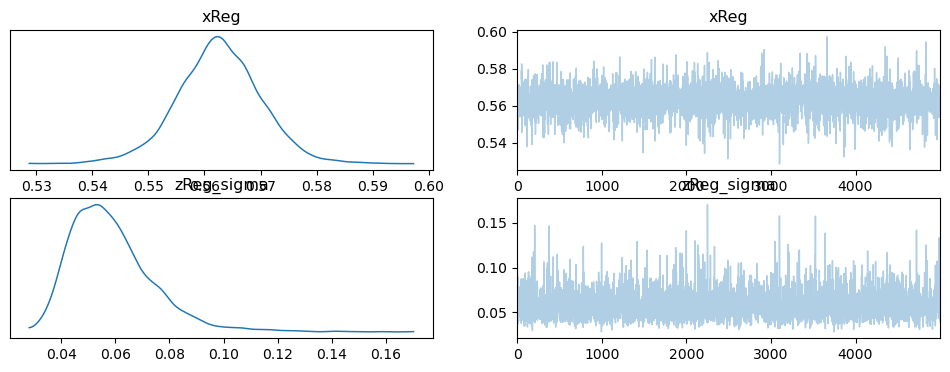

In [6]:
import arviz as az
import bambi as bmb
import pandas as pd

# Read in a tab-delimited file containing our data
dataReg = pd.DataFrame(data=np.array([zReg,xReg]).T, columns=["zReg","xReg"])
dataRan = pd.DataFrame(data=np.array([zRan,xRan]).T, columns=["zRan","xRan"])

# Initialize the fixed effects only model
modelReg = bmb.Model('zReg ~ 0 + xReg', dataReg)
modelRan = bmb.Model('zRan ~ 0 + xRan', dataRan)

#fitted=model.fit()

# Fit the model using 1000 on each of 4 chains
resultsReg = modelReg.fit(draws=5000, chains=1)
resultsRan = modelRan.fit(draws=5000, chains=1)

# Use ArviZ to plot the results
az.plot_trace(resultsReg)

# Key summary and diagnostic info on the model parameters
az.summary(resultsReg)


arviz - WARNING - Shape validation failed: input_shape: (1, 5000), minimum_shape: (chains=2, draws=4)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
xRan,0.554,0.006,0.543,0.566,0.0,0.0,3340.0,2512.0,NaN
zRan_sigma,0.054,0.014,0.032,0.080,0.0,0.0,3167.0,2862.0,NaN


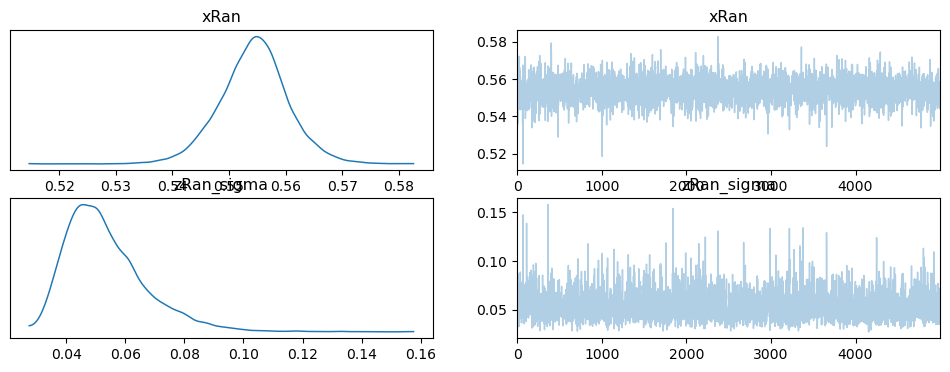

In [7]:
# Use ArviZ to plot the results
az.plot_trace(resultsRan)

# Key summary and diagnostic info on the model parameters
az.summary(resultsRan)

In [8]:
modelReg

       Formula: zReg ~ 0 + xReg
        Family: gaussian
          Link: mu = identity
  Observations: 11
        Priors: 
    target = mu
        Common-level effects
            xReg ~ Normal(mu: 0.0, sigma: 1.346)
        
        Auxiliary parameters
            zReg_sigma ~ HalfStudentT(nu: 4.0, sigma: 0.664)
------
* To see a plot of the priors call the .plot_priors() method.
* To see a summary or plot of the posterior pass the object returned by .fit() to az.summary() or az.plot_trace()

Sampling: [xReg, zReg_sigma]


array([<Axes: title={'center': 'zReg_sigma'}>,
       <Axes: title={'center': 'xReg'}>], dtype=object)

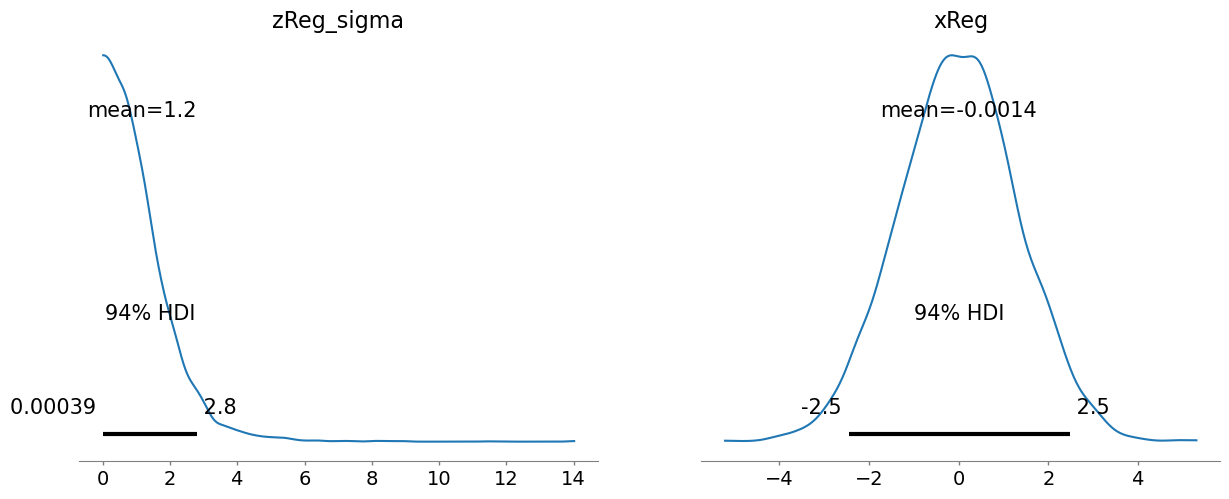

In [9]:
modelReg.plot_priors()

# GP Model Discrepancy

$z$: observations (nx1)

$x$: observation locations (nx1)

$\delta_0$ Model discrepancy at 6 chosen points

$\delta_r$ Model discrepancy at remaining points

$H$: nx6 matrix used to calculate conditional mean of $\delta_r$ given $\delta_0$

$\Gamma(\phi)$: Gaussian correlation function with lengthscale $\phi$

In [10]:
xo = xReg[[0,2,4,6,8,10]]
xr = xReg[[1,3,5,7,9]]

In [11]:
zo = zReg[[0,2,4,6,8,10]]
zr = zReg[[1,3,5,7,9]]

In [12]:
def createGamma(x1,x2,phi):
    gamma = np.zeros([len(x1),len(x2)])
    for i,xi in enumerate(x1):
        for j,xj in enumerate(x2):
            gamma[i,j] = np.exp(-((xi-xj)/phi)**2)
    return gamma

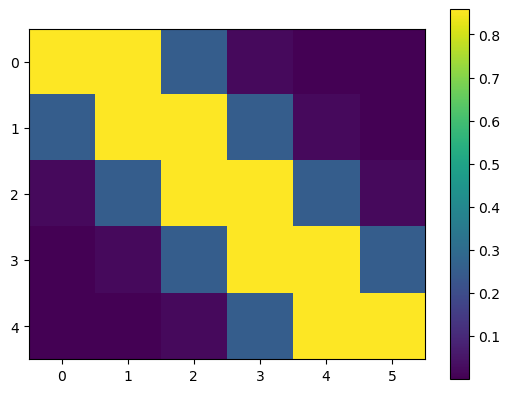

In [13]:
plt.imshow(createGamma(xr,xo,1))
plt.colorbar()

In [14]:
xr

array([0.49, 1.27, 2.05, 2.83, 3.61])

In [15]:
xo

array([0.1 , 0.88, 1.66, 2.44, 3.22, 4.  ])

In [16]:
def createH(xo,xr,phi):
    
    H = np.zeros([len(xr)+len(xo),len(xo)])
    H[0:len(xo),:]=np.identity(len(xo))
    gamma_ro = createGamma(xr,xo,phi)
    gamma_oo = createGamma(xo,xo,phi)
    H[len(xo):len(xr)+len(xo),:] = np.matmul(gamma_ro,np.linalg.inv(gamma_oo))
    return H

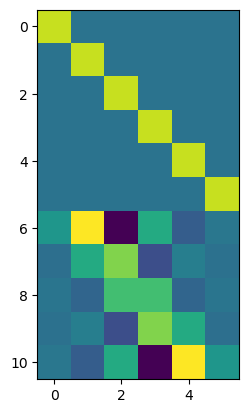

In [17]:
plt.imshow(createH(xo,xr,4))

In [18]:
def ThetaConditional(xo,xr,xp,zo,zr,sigma_e,phi):
        
    x=np.hstack((xo,xr))[:,None]
    z=np.hstack((zo,zr))[:,None]
    H = createH(xo,xr,phi)
    gamma_opop = createGamma(np.hstack((xo,xp)),np.hstack((xo,xp)),phi)
    A=np.hstack((H,np.zeros([len(xo)+len(xr),len(xp)])))
    m1=(1/sigma_e**2)*np.matmul(x.T,z)
    m2=(1/sigma_e**2)*np.matmul(H.T,z)
    m3 = np.zeros((len(xp),1))
    m = np.vstack((m1,m2,m3)) 
    
                  
    sigma1 = (1/sigma_e**2)*np.matmul(x.T,x)
    sigma2 = (1/sigma_e**2)*np.matmul(x.T,A)
    sigma3 = (1/sigma_e**2)*np.matmul(A.T,x)
    sigma4 = (1/sigma_e**2)*np.matmul(A.T,A) + (1/sigma_e**2)*np.linalg.inv(gamma_opop)
    sigma = np.vstack((np.hstack((sigma1, sigma2)), np.hstack((sigma3, sigma4))))
    sigmaInv = np.linalg.inv(np.array(sigma))
    mu = np.squeeze(np.matmul(sigmaInv,m))
    
    return mu, sigmaInv
                  

In [19]:
xp=[]

In [20]:
mu,sigmaInv = ThetaConditional(xo,xr,xp,zo,zr,0.1,1)

In [21]:
mu

array([ 0.55789766,  0.01427378,  0.04330435,  0.05630222,  0.0412512 ,
        0.00078929, -0.03191602])

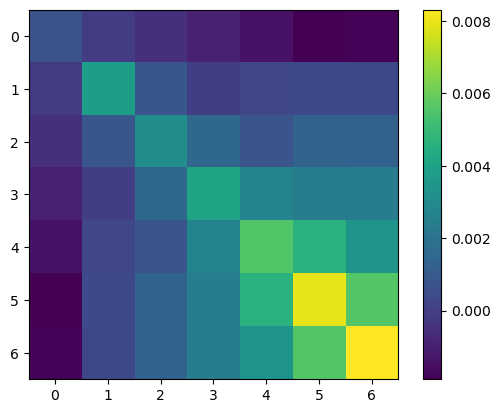

In [22]:
plt.imshow(sigmaInv)
plt.colorbar()

In [23]:
def sigma2Conditional(a,b,xo,phi,deltao):
    gamma_oo_inv = np.linalg.inv(createGamma(xo,xo,phi))
    shape = a + 0.5*len(xo)
    scale = b + 0.5*np.matmul(np.matmul(deltao.T,gamma_oo_inv),deltao)
    return shape, scale

In [24]:
def sigma_e2Conditional(a_e,b_e,xo,xr,zo,zr,phi,theta,deltao):
    x=np.hstack((xo,xr))
    z=np.hstack((zo,zr))
    H = createH(xo,xr,phi)
    gamma_oo = createGamma(xo,xo,phi)
    shape = a_e + 0.5*(len(xo)+len(xr))
    scale = b_e + 0.5*np.matmul((z-theta*x-np.matmul(H,deltao)).T,z-theta*x-np.matmul(H,deltao))
    return shape, scale

In [25]:
def phiChoiceProbability(omega_old,omega_new,xo,xr,a_phi,b_phi,deltao,sigma2,sigma_e2):
    x=np.hstack((xo,xr))
    z=np.hstack((zo,zr))
    H_old = createH(xo,xr,np.exp(omega_old))
    H_new = createH(xo,xr,np.exp(omega_new))
    gamma_old = createGamma(xo,xo,np.exp(omega_old))
    gamma_new = createGamma(xo,xo,np.exp(omega_new))
    logr =  0.5*np.log(np.linalg.det(gamma_old)) - 0.5*np.log(np.linalg.det(gamma_new))+(omega_new-omega_old)*a_phi-(np.exp(omega_new)-np.exp(omega_old))*b_phi - (1/(2*sigma2))*np.matmul(np.matmul(deltao.T,np.linalg.inv(gamma_new)-np.linalg.inv(gamma_old)),deltao)-(1/(2*sigma_e2))*np.matmul((z-theta*x-np.matmul(H_new,deltao)).T,(z-theta*x-np.matmul(H_new,deltao)))+(1/(2*sigma_e2))*np.matmul((z-theta*x-np.matmul(H_new,deltao)).T,(z-theta*x-np.matmul(H_old,deltao)))
    return logr

In [26]:
import scipy

In [27]:
def gibbs_sampler(theta,deltao,deltap,sigma2,sigma_e2,phi, num_samples, xo, xr, xp, zo, zr,tau2,a,b,a_e,b_e,a_phi,b_phi):
    dim = 1+len(deltao)+len(deltap)+1+1+1
    samples = np.empty([num_samples+1, dim])  #sampled points
    samples[0] = np.hstack((theta,deltao,deltap,sigma2,sigma_e2,phi))
    param = np.hstack((theta,deltao,deltap))
    acceptance = np.zeros(num_samples)
    s=0
    for i in range(num_samples):
        mu, sigma = ThetaConditional(xo,xr,xp,zo,zr,np.sqrt(sigma_e2),phi)
        param = np.random.multivariate_normal(mu,sigma)
        
        theta=param[0]
        deltao=param[1:len(deltao)+1]
        deltap = param[len(deltao):]
        
        shape, scale = sigma2Conditional(a,b,xo,phi,deltao)
        
        sigma2 = scipy.stats.invgamma.rvs(shape,scale=scale)
        
        shape, scale = sigma_e2Conditional(a_e,b_e,xo,xr,zo,zr,phi,theta,deltao)
        sigma_e2 = scipy.stats.invgamma.rvs(shape,scale=scale)
        
        
        omega_old = np.log(phi)
        
        omega_new = np.minimum(np.random.normal(omega_old,tau2),np.log(4))
        
        r = phiChoiceProbability(omega_old,omega_new,xo,xr,a_phi,b_phi,deltao,sigma2,sigma_e2)
        
        if np.random.uniform(0,1)<np.exp(r):
            phi = np.exp(omega_new)
            s+=1
            
        
        acceptance[i]=s/(i+1)
        samples[i+1] = np.hstack((param,sigma2,sigma_e2,phi))
    return samples, acceptance

In [28]:
deltao=0.01*np.ones(len(xo))
shape, scale = sigma_e2Conditional(9.526,0.000853,xo,xr,zo,zr, 3,0.6,deltao)
scipy.stats.invgamma.rvs(shape,scale=scale)

0.0056528628279704516

In [29]:
scale

0.06515913268443858

In [30]:
scipy.stats.invgamma.rvs(shape,scale=0.1)

0.008240564753036094

In [31]:
xp=[]

In [32]:
samples, acceptance = gibbs_sampler(theta=0.1,deltao=np.zeros(len(xo)),deltap=np.zeros(len(xp)),sigma2=0.01,sigma_e2=0.01,phi=0.01, num_samples=100000, xo=xo, xr=xr, xp=xp, zo=zo, zr=zr,tau2=0.1,a=2.6,b=0.144,a_e=9.526,b_e=0.000853,a_phi=1,b_phi=0.2)

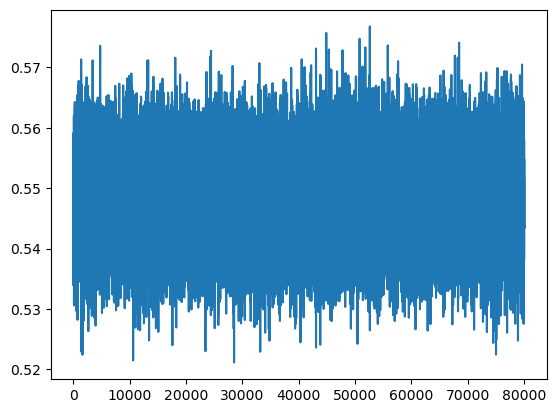

In [42]:
plt.plot(samples[20000:,0])

(array([3.0000e+01, 3.0200e+02, 2.6510e+03, 1.2841e+04, 2.8492e+04,
        2.4906e+04, 9.0780e+03, 1.5180e+03, 1.6600e+02, 1.7000e+01]),
 array([0.52114403, 0.52670528, 0.53226653, 0.53782777, 0.54338902,
        0.54895027, 0.55451151, 0.56007276, 0.56563401, 0.57119525,
        0.5767565 ]),
 <BarContainer object of 10 artists>)

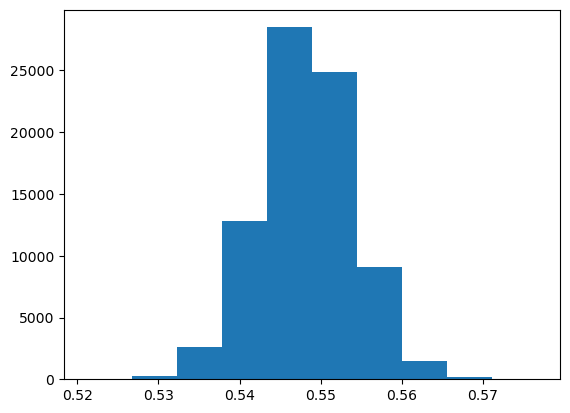

In [34]:
plt.hist(samples[20000:,0])

In [35]:
np.mean(samples[20000:,0])

0.548205478731529

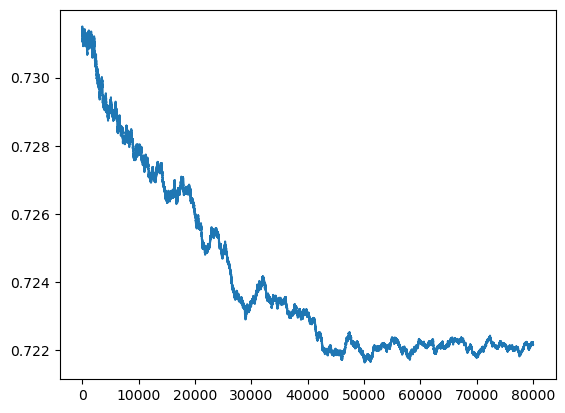

In [36]:
plt.plot(acceptance[20000:])

In [37]:
acceptance

array([1.        , 1.        , 1.        , ..., 0.72215444, 0.72214722,
       0.72215   ])

# Emulator

In [38]:
thetas = np.linspace(0,5,100)

In [39]:
data = np.multiply(thetas[:,None],xo[:,None].T)

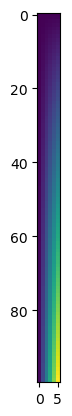

In [40]:
plt.imshow(data)

In [41]:
import torch
import gpytorch

$Z=X\theta + \delta + \epsilon$

$Z=[Z_o, Z_r]$ 

$X=[X_o,X_r]$ 

$\delta = [\delta_o, \delta_r]$

$\delta_r,\delta_o \sim N(0, \sigma^2\Lambda(\phi))$

$\epsilon \sim N(0,\sigma_e^2I)$

Theta has an improper flat prior

Trying to find $Z|\delta_o,\sigma^2,\phi,\sigma_e^2$. 

In the paper they say $Z|\delta_o,\sigma^2,\phi,\sigma_e^2 \sim N(X\theta + H(\phi)\delta_o,\sigma_e^2I)$ where $H(\phi)$ is the identity matrix for rows relating to $\delta_o$ and $\Lambda_{or}\Lambda_{rr}^{-1}$ for rows relating to $\delta_r$. 

To me, this doesn't seem to account for the variance in $\delta_r$. From standard results we know that $\delta_r|\delta_o,\sigma^2,\phi,\sigma_e^2 \sim N(\Lambda_{or}\Lambda_{rr}^{-1}\delta_o,\sigma^2(\Lambda_{oo}-\Lambda_{or}\Lambda_{rr}^{-1}\Lambda_{ro}))$ - shouldn't this variance turn up in the above expression for $Z$? Am I being silly?
